In [1]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('../data/features.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

In [3]:
df = df.drop(columns=["direccion","id","descripcion","titulo"])
#"lat","lng",

In [4]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [5]:
df1 = imputar(df)

oneHot = ['tipodepropiedad','provincia']
label = ['ciudad']

cat_features = ['ciudad','tipodepropiedad','provincia']

df1 = df1.dropna(subset=cat_features)

In [6]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [7]:
def transformar(df,colums):
    for x in colums:
        df[x]=df[x].transform(lambda y: np.sqrt(y))
        
columnas_para_transformar = ["metroscubiertos","metrostotales","metroscubiertostotales"]

#transformar(df1,columnas_para_transformar)

In [8]:
df1["metroscubiertostotales"]=df1["metroscubiertos"]+df1["metrostotales"]
df1["ambientes"]=df1["banos"]+df1["habitaciones"]
df1["ambientesygarage"]=df1["banos"]+df1["habitaciones"]+df1["garages"]

In [9]:
data_cols = df1._get_numeric_data().columns
baseline_data = df1[data_cols]

encoder = ce.OneHotEncoder()

encoded = encoder.fit_transform(df1[oneHot])
data = baseline_data.join(encoded)

encoder = ce.BinaryEncoder()

encoded = encoder.fit_transform(df1[label])
data = data.join(encoded)

x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(239954, 100) y=(239954,)
Train shapes: X=(191963, 100) y=(191963,)
Test  shapes: X=(47991, 100)  y=(47991,)


In [10]:
xgb_model = XGBRegressor(n_estimators=400,max_depth=10,n_jobs=-1,objective="reg:squarederror")


In [11]:
xgb_model.fit(x_train, y_train)

/home/peter/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [12]:
predecir(xgb_model,x_train,y_train,x_test,y_test)

Entrenamiento: 94.3028%
Testeo: 82.5064%.


0.8250644919242607

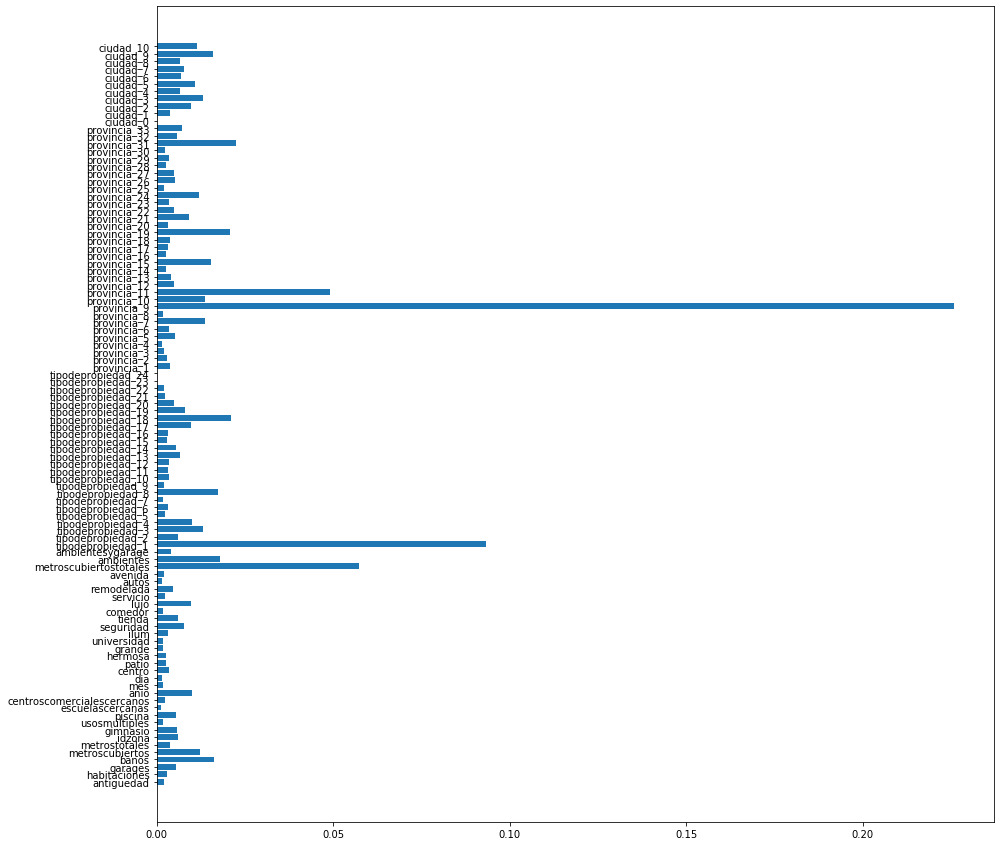

In [13]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = xgb_model.feature_importances_
ax = plt.barh(x.columns, xgb_model.feature_importances_)